In [11]:
import numpy             as np
import matplotlib.pyplot as plt
import torch

from libraries.graph         import graph_POSCAR_encoding
from libraries.model         import diffuse, get_alpha_t
from torch_geometric.data    import Data, Batch
from pymatgen.core.structure import Structure

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [49]:
# Machine-learning parameters
n_epochs      = 1000
batch_size    = 128
learning_rate = 0.0001

# Number of diffusing and denoising steps
n_t_steps = 500

# Decay of parameter alpha
noise_contribution = 0.1
alpha_decay = 0.5 * (1 - noise_contribution**2)

# Dropouts for node and edge models (independent of each other)
dropout_node = 0.2
dropout_edge = 0.2

# Diffusion

In [50]:
#graph = get_random_graph(5, 1)

temp_structure = Structure.from_file('POSCAR')

nodes, edges, attributes = graph_POSCAR_encoding(temp_structure)

# Construct temporal graph structure
graph = Data(x=nodes,
             edge_index=edges.t().contiguous(),
             edge_attr=attributes.ravel(),
             y=torch.tensor([0], dtype=torch.float)             
             )

graph.x         = (graph.x         - torch.mean(graph.x, axis=0)) / torch.std(graph.x, axis=0)
graph.edge_attr = (graph.edge_attr - torch.mean(graph.edge_attr)) / torch.std(graph.edge_attr)

In [52]:
batch_t = Batch.from_data_list([graph]).to(device)

diffused_grap, all_graphs = diffuse(batch_t, n_t_steps,
                        s=alpha_decay,
                        plot_steps=False, ouput_all_graphs=True)

In [53]:
# Number of time steps (nt), nodes (ng), and features per node (nf)
nt = len(all_graphs)
ng = all_graphs[0].x.size(0)  # Number of nodes
nf = all_graphs[0].x.size(1)  # Number of features per node
ne = all_graphs[0].edge_attr.size(0)  # Number of edges in each graph

# Initialize a NumPy array to store the evolution of node features
node_features_evolution = np.zeros((nt, ng, nf))

# Initialize a NumPy array to store the evolution of edge attributes
edge_attr_evolution = np.zeros((nt, ne))  # Scalar edge attributes

# Fill the NumPy array with node features
for t in range(nt):
    node_features_evolution[t] = all_graphs[t].x.cpu().numpy()  # Move to CPU if on GPU
    edge_attr_evolution[t] = all_graphs[t].edge_attr.cpu().numpy()

# Now, you can access the evolution of any specific node i
node_i = 5  # Example: Node index 5
feature_evolution = node_features_evolution[:, node_i, :]  # Shape: (nt, nf)

# Now, you can access the evolution of any specific edge
edge_idx = 100  # Example: Edge index 100
edge_feature_evolution = edge_attr_evolution[:, edge_idx]  # Shape: (nt,)

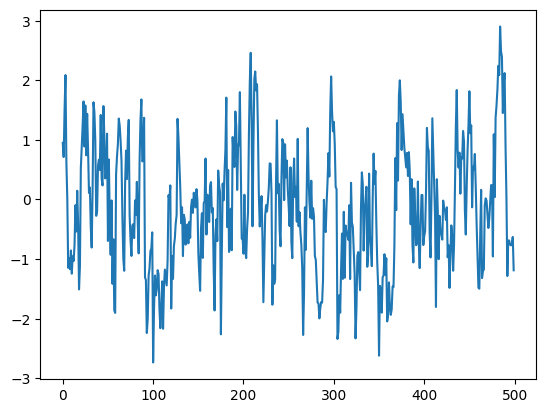

In [56]:
plt.plot(feature_evolution[:, 0])

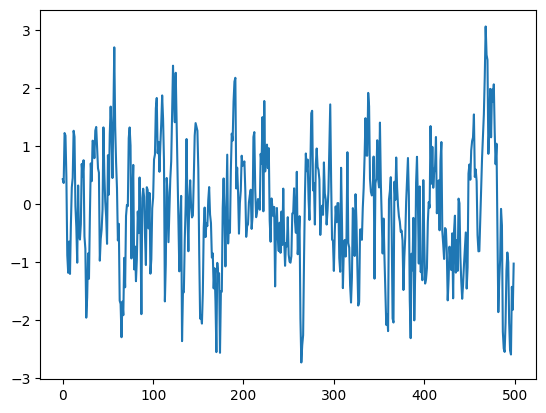

In [65]:
plt.plot(edge_feature_evolution)

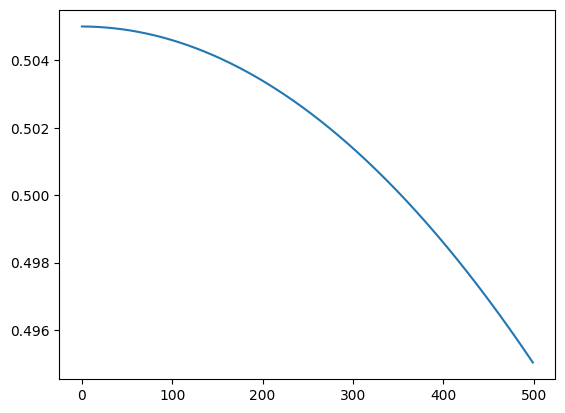

In [14]:
# Plot alpha_t parameter
alphas = get_alpha_t(np.arange(1, n_t_steps+1), n_t_steps, s=alpha_decay)
plt.plot(alphas.cpu().numpy())